<a href="https://colab.research.google.com/github/jayblue27/works4_myself/blob/main/%5B%ED%95%84%EC%82%AC%5D_%EC%B4%88%EA%B0%84%EB%8B%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98(%EC%83%98%ED%94%8C%EB%AC%B8%EC%9E%A5%2C%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC%EB%AA%A8%EB%8D%B8%ED%99%9C%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 샘플 문장으로 벡터화 및 간단한 분류모델 실행
- 기억할 것
  - 벡터화 복습
  - 시각화 한글폰트 적용하는 코드
  - 마지막 시각화 부분(결정트리 및 피쳐임포턴스)

In [1]:
# 사이킷런 1.0 넘어오면서 많은 기능이 업데이트 됨
# sklearn 1.0 이상의 버전 사용
import sklearn

sklearn.__version__

'1.0.2'

- 데이터 로드  
- 텍스트 데이터 전처리 
- 덱스트 데이터 벡터화 (BOW, TF-IDF) 
- 데이터 나누기 train_test_split 
  - 학습세트
  - 예측세트

    - 모델
    - 학습
    - 예측
    - 평가

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from inspect import findsource
def get_font_family():
    '''
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    '''
    import platform
    system_name = platform.system()

    if system_name == 'Darwin' :
        font_faimly = 'AppleGothic'
    elif system_name == 'Windows':
        font_family = 'Malgun Gothic'
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = 'NanumBarunGothic'

    return font_family

plt.style.use('seaborn')
plt.rc('font',family=get_font_family())
plt.rc('axes', unicode_minus = False)

%config InlineBeackend.figure_format = 'retina'

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [4]:
get_font_family()

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


'NanumBarunGothic'

# 예제 문서 만들기

In [5]:
corpus = ['코로나 거리두기와 코로나 상생지원금 문의입니다.',
          '지하철 운행시간과 지하철 요금 문의입니다.',
          '지하철 승강장 문의입니다.',
          '코로나 선별진료소 문의입니다.',
          '버스 운행시간 문의입니다.',
          '버스 터미널 위치 안내입니다.',
          '코로나 거리두기 안내입니다.',
          '택시 승강장 문의입니다.'
          ]

In [6]:
#padas의 데이터프레임 형식으로 만든다.
df = pd.DataFrame(corpus, columns=['문서'])
df

,문서
0,코로나 거리두기와 코로나 상생지원금 문의입니다.
1,지하철 운행시간과 지하철 요금 문의입니다.
2,지하철 승강장 문의입니다.
3,코로나 선별진료소 문의입니다.
4,버스 운행시간 문의입니다.
5,버스 터미널 위치 안내입니다.
6,코로나 거리두기 안내입니다.
7,택시 승강장 문의입니다.


# 정답 데이터 만들기
- 코로나 들어가면 ' 보건'으로 그 외는 ' 교통으로 레이블링

In [7]:
#str.contains를 통해 특정 텍스트가 들어가는 여부를 알 수있다.
# '코로나'가 들어가는 텍스트 찾기
df['문서'].str.contains('코로나')

0     True
1    False
2    False
3     True
4    False
5    False
6     True
7    False
Name: 문서, dtype: bool

In [8]:
#loc[행,열]
#loc[조건, 열]
#loc[조건, 열] = 대체값으로 특정 열에 해당하는 값을 변경
#'코로나'가 포함이면 '보건'으로 나머지는 '교통'으로 정답을 레이블링

df.loc[df['문서'].str.contains('코로나'), '분류'] = '보건'
df.loc[~df['문서'].str.contains('코로나'), '분류'] = '교통'
df

,문서,분류
0,코로나 거리두기와 코로나 상생지원금 문의입니다.,보건
1,지하철 운행시간과 지하철 요금 문의입니다.,교통
2,지하철 승강장 문의입니다.,교통
3,코로나 선별진료소 문의입니다.,보건
4,버스 운행시간 문의입니다.,교통
5,버스 터미널 위치 안내입니다.,교통
6,코로나 거리두기 안내입니다.,보건
7,택시 승강장 문의입니다.,교통


In [9]:
#잘 만들어졌는지 확인하기
df

,문서,분류
0,코로나 거리두기와 코로나 상생지원금 문의입니다.,보건
1,지하철 운행시간과 지하철 요금 문의입니다.,교통
2,지하철 승강장 문의입니다.,교통
3,코로나 선별진료소 문의입니다.,보건
4,버스 운행시간 문의입니다.,교통
5,버스 터미널 위치 안내입니다.,교통
6,코로나 거리두기 안내입니다.,보건
7,택시 승강장 문의입니다.,교통


In [10]:
#정답 값 빈도수 확인하기
df['분류'].value_counts()

교통    5
보건    3
Name: 분류, dtype: int64

# 텍스트 데이터 수치 형태로 변경하기

In [15]:
# sklearn.feature_extraction.text의 CountVetorizer로 BOW 벡터화
# fit_transform 으로 변환하기
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer()
dtm = cvect.fit_transform(df['문서'])
dtm

<8x16 sparse matrix of type '<class 'numpy.int64'>'
	with 27 stored elements in Compressed Sparse Row format>

#DTM(document-term matrix)

In [19]:
# 피처 가져오기
#get_feature_names is deprecated in 1.0 and will be removed in 1.2
# feature_names
# cvect.get_feature_names() -> 사라질 예정인 기능
feature_names = cvect.get_feature_names_out()
feature_names

array(['거리두기', '거리두기와', '문의입니다', '버스', '상생지원금', '선별진료소', '승강장', '안내입니다',
       '요금', '운행시간', '운행시간과', '위치', '지하철', '코로나', '택시', '터미널'],
      dtype=object)

In [20]:
# 단어사전 보기
cvect.vocabulary_

{'거리두기': 0,
 '거리두기와': 1,
 '문의입니다': 2,
 '버스': 3,
 '상생지원금': 4,
 '선별진료소': 5,
 '승강장': 6,
 '안내입니다': 7,
 '요금': 8,
 '운행시간': 9,
 '운행시간과': 10,
 '위치': 11,
 '지하철': 12,
 '코로나': 13,
 '택시': 14,
 '터미널': 15}

In [23]:
df

,문서,분류
0,코로나 거리두기와 코로나 상생지원금 문의입니다.,보건
1,지하철 운행시간과 지하철 요금 문의입니다.,교통
2,지하철 승강장 문의입니다.,교통
3,코로나 선별진료소 문의입니다.,보건
4,버스 운행시간 문의입니다.,교통
5,버스 터미널 위치 안내입니다.,교통
6,코로나 거리두기 안내입니다.,보건
7,택시 승강장 문의입니다.,교통


In [22]:
#dtm(document-term matrix)
# sparse matrix -> 0이 많음,등장하지 않는다.
pd.DataFrame(dtm.toarray(), columns=feature_names)

,거리두기,거리두기와,문의입니다,버스,상생지원금,선별진료소,승강장,안내입니다,요금,운행시간,운행시간과,위치,지하철,코로나,택시,터미널
0,0,1,1,0,1,0,0,0,0,0,0,0,0,2,0,0
1,0,0,1,0,0,0,0,0,1,0,1,0,2,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
6,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0


# 문제와 정답 만들기

In [31]:
# 독립변수로 사용할 x 변수에 dtm array를 할당
# 예) 시험문제

#계산은 수치 데이터만 가능하기 때문에
X = dtm.toarray()
X

array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [32]:
# 종속변수로 사용할 y 변수에 정답값인 'category' 값을 할당
y = df['분류']
y

0    보건
1    교통
2    교통
3    보건
4    교통
5    교통
6    보건
7    교통
Name: 분류, dtype: object

# 데이터셋 나누기
- train, test 나눌 때

In [29]:
# 8:2의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담는다.
# split_count
split_count = int(df.shape[0] * 0.8)
split_count

6

In [34]:
# 학습 세트 만들기 ex) 시험의 기출문제
# 학습 세트의 정답 만들기 ex) 기출문제의 정답
# X_train, y_train
X_train = X[:split_count]
y_train = y[:split_count]
print(X_train.shape, y_train.shape)
print()
X_train, y_train

(6, 16) (6,)



(array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]]), 0    보건
 1    교통
 2    교통
 3    보건
 4    교통
 5    교통
 Name: 분류, dtype: object)

In [40]:
# 예측 세트 만들기 예) 실전 시험문제
X_test = X[split_count:]
y_test = y[split_count:]
print(X_test.shape, y_test.shape)
print()
print(X_test)
print()
print(y_test)

(2, 16) (2,)

[[1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0]]

6    보건
7    교통
Name: 분류, dtype: object


# 머신러닝 모델 로드하기

In [41]:
# DecisionTreeClassifier를 사용
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

#학습(훈련)

In [42]:
#fit(기출문제, 정답)
model.fit(X_train, y_train)

DecisionTreeClassifier()

#예측

In [43]:
#predict(실전문제)
y_pred = model.predict(X_test)
y_pred

array(['보건', '교통'], dtype=object)

#평가
### 정확도(Accruarcy) 측정하기

In [45]:
# 예측의 정확도 구하기
(y_test == y_pred).mean() * 100

100.0

In [46]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

1.0

In [49]:
# crosstab으로 confusion matrix 구하기
pd.crosstab(y_test, y_pred)

col_0,교통,보건
분류,,
교통,1,0
보건,0,1


In [51]:
# 라이브러리 활용
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1, 0],
       [0, 1]])

#트리 알고리즘 분석
### 시각화

In [52]:
# export_text로 트리 분석하기
from sklearn.tree import export_text

print(export_text(model))

|--- feature_13 <= 0.50
|   |--- class: 교통
|--- feature_13 >  0.50
|   |--- class: 보건



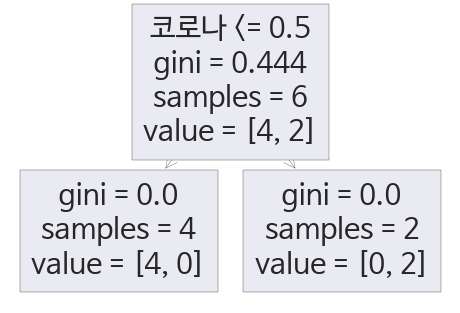

In [54]:
#plot_tree로 시각화
from sklearn.tree import plot_tree

plot_tree(model, feature_names=feature_names);

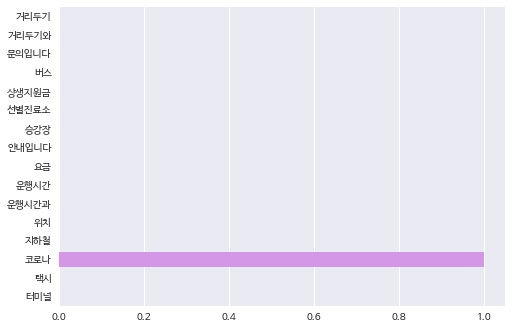

In [56]:
#feature_importances 로 피처 중요도 확인하기
sns.barplot(x = model.feature_importances_, y = feature_names);